In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [2]:
from neo4j import GraphDatabase

uri = "bolt://localhost:7687"  
username = "neo4j"     
password = "foodContamination" #This is whatever password you set when you are created your database    

driver = GraphDatabase.driver(uri, auth=(username, password))

In [3]:
cypher_query = """MATCH (n) 
OPTIONAL MATCH (n)-[r]->(m) 
RETURN n, r, m"""

In [4]:
with driver.session() as session:
    result = session.run(cypher_query)

    # Extract properties and relationships from nodes
    data = []
    for record in result:
        node = record['n']
        properties = dict(node.items())
        relationship = record['r']
        if relationship is not None:
            relationship_properties = dict(relationship.items())
        else:
            relationship_properties = {}
        data.append({**properties, **relationship_properties})

    # Create DataFrame from the data
    df = pd.DataFrame(data)

In [5]:
df2 = df[['commodity','eventID', 'gtin', 'sgln', 'cteDate', 'pgln', 'contaminated', 'shortDescription']]
df2 = df2.dropna(how='all')

In [6]:
df2['cteDate'] = pd.to_datetime(df2['cteDate'])
reference_date = pd.to_datetime('1970-01-01')
df2['cteDate'] = (df2['cteDate'] - reference_date).dt.days.astype(float)

df2['commodity'] = df2['commodity'].fillna(df2['shortDescription'])

In [7]:
df2 = df2.drop('shortDescription', axis=1)

In [8]:
df2['eventID'] = pd.to_numeric(df2['eventID'].str.replace('.', ''))
df2['gtin'] = pd.to_numeric(df2['gtin'].str.replace('.', ''))
df2['sgln'] = pd.to_numeric(df2['sgln'].str.replace('.', ''))
df2['pgln'] = pd.to_numeric(df2['pgln'].str.replace('.', ''))

C:\Users\andre\AppData\Local\Temp\ipykernel_12024\2049791979.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df2['eventID'] = pd.to_numeric(df2['eventID'].str.replace('.', ''))
C:\Users\andre\AppData\Local\Temp\ipykernel_12024\2049791979.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df2['gtin'] = pd.to_numeric(df2['gtin'].str.replace('.', ''))
C:\Users\andre\AppData\Local\Temp\ipykernel_12024\2049791979.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df2['sgln'] = pd.to_numeric(df2['sgln'].str.replace('.', 

In [9]:
# Define the columns to be one-hot encoded
columns_to_encode = ['commodity']

# Create the ColumnTransformer
transformer = ColumnTransformer([('one_hot_encoder', OneHotEncoder(), columns_to_encode)], remainder='passthrough')

# Apply the transformation
df_encoded = transformer.fit_transform(df2)

# Convert the encoded data to a DataFrame
df3 = pd.DataFrame(df_encoded.toarray(), columns=transformer.get_feature_names_out(df2.columns))

In [10]:
X = df3.drop('remainder__contaminated', axis=1)
y = df3['remainder__contaminated'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [13]:
# Predict probabilities for the positive class
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Compute AUC
auc = roc_auc_score(y_test, y_pred_proba)
print("AUC:", auc)

AUC: 0.9549622223687755


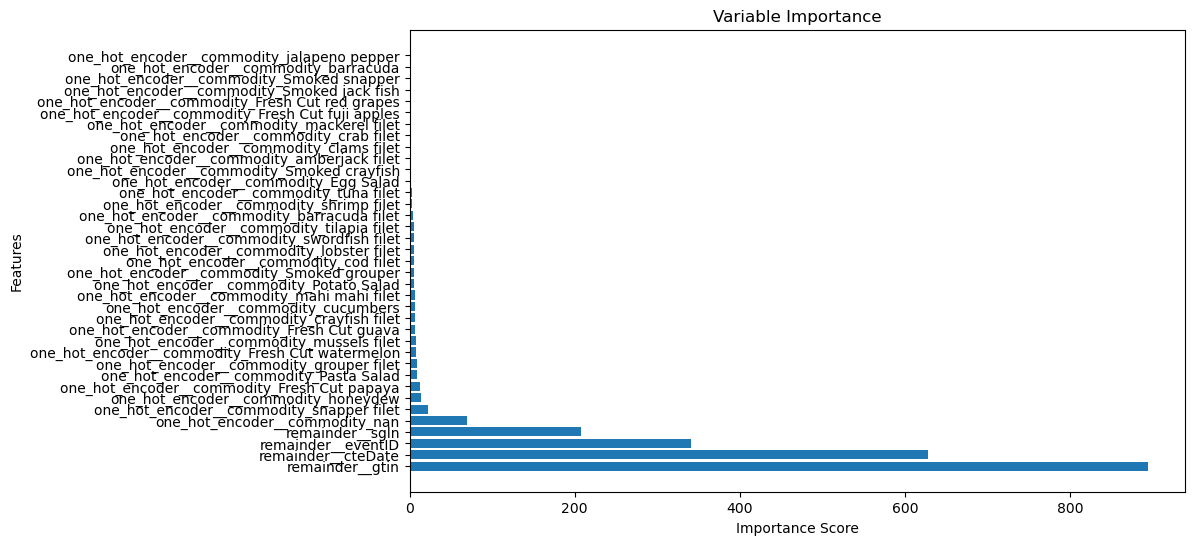

In [15]:
# Get the feature names from the DataFrame
feature_names = X_train.columns

# Create a DMatrix for feature importance
dmatrix = xgb.DMatrix(X_train, feature_names=feature_names)

# Retrieve the feature importance scores
importance_scores = model.get_booster().get_score(importance_type='weight')

# Create lists to store the feature names and importance scores
features = []
scores = []

# Iterate over the feature importance scores
for feature, score in importance_scores.items():
    features.append(feature)
    scores.append(score)

# Sort the feature names and importance scores by score
sorted_indices = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)
sorted_features = [features[i] for i in sorted_indices]
sorted_scores = [scores[i] for i in sorted_indices]

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_scores)
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Variable Importance')
plt.show()